<a href="https://colab.research.google.com/github/davidofitaly/neural_network/blob/main/06_cnn/02_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import of libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

###Loading data

In [3]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2024-11-11 10:30:02--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 172.253.117.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  25.1MB/s    in 71s     

2024-11-11 10:31:15 (20.6 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



###Preparation of training, validation and test collections

In [4]:
!rm -rf ./images

In [5]:
base_dir = './data/planes'

raw_no_of_files = {}

classes =  ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [6]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [7]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [8]:
size = min(len(drone_fnames), len(passenger_fnames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [9]:
for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst)

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


###Data mining

####Select the index of a sample drone photo from the training collection:

(-0.5, 2047.5, 1151.5, -0.5)

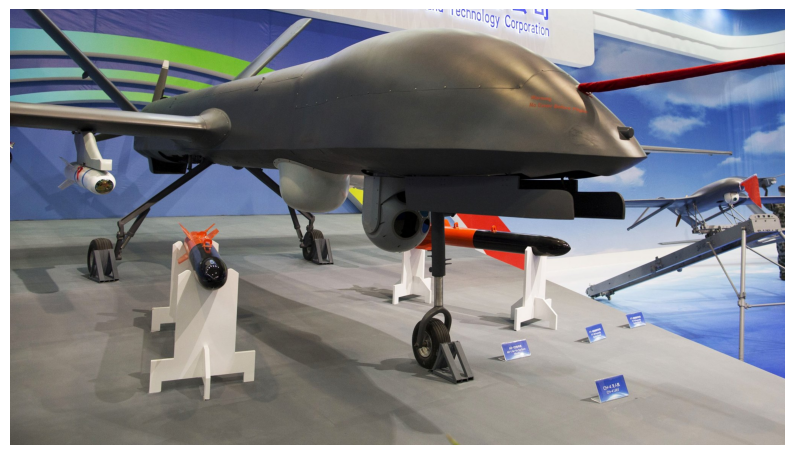

In [10]:
idx = 681  #@param {type: 'slider', min:0, max:919}

names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 2047.5, 1535.5, -0.5)

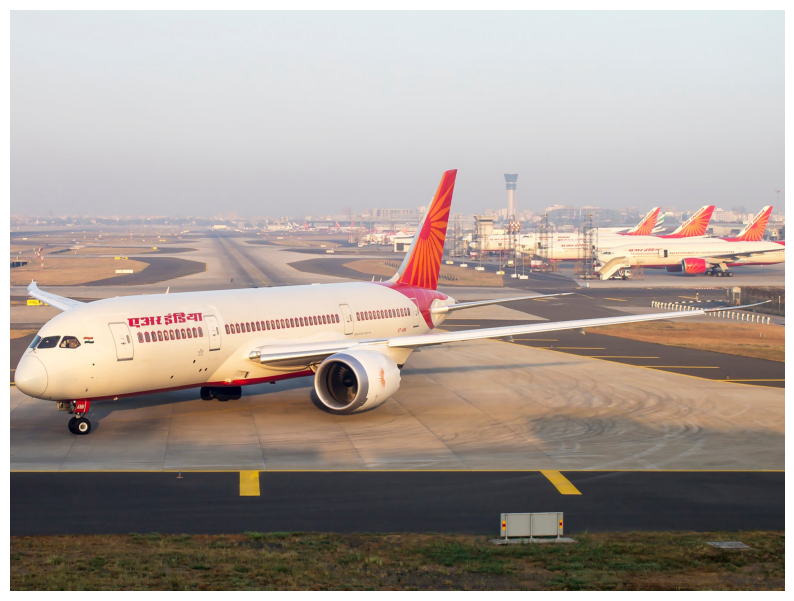

In [11]:
idx = 723  #@param {type: 'slider', min:0, max:919}

names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

###Data augmentation

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [13]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

###Drone training collection:

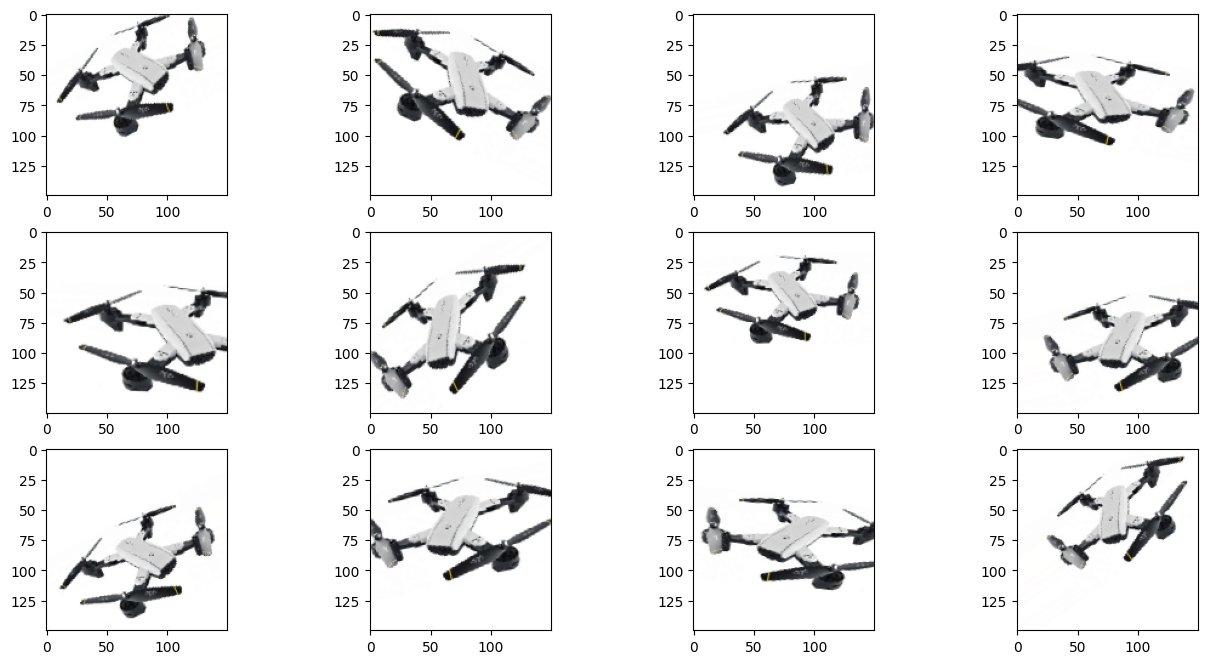

In [14]:
idx = 624 #@param {type: 'slider', mnin:0, max:919}

display_augmented_images(train_drone_dir, idx)

###Passenger training collection:

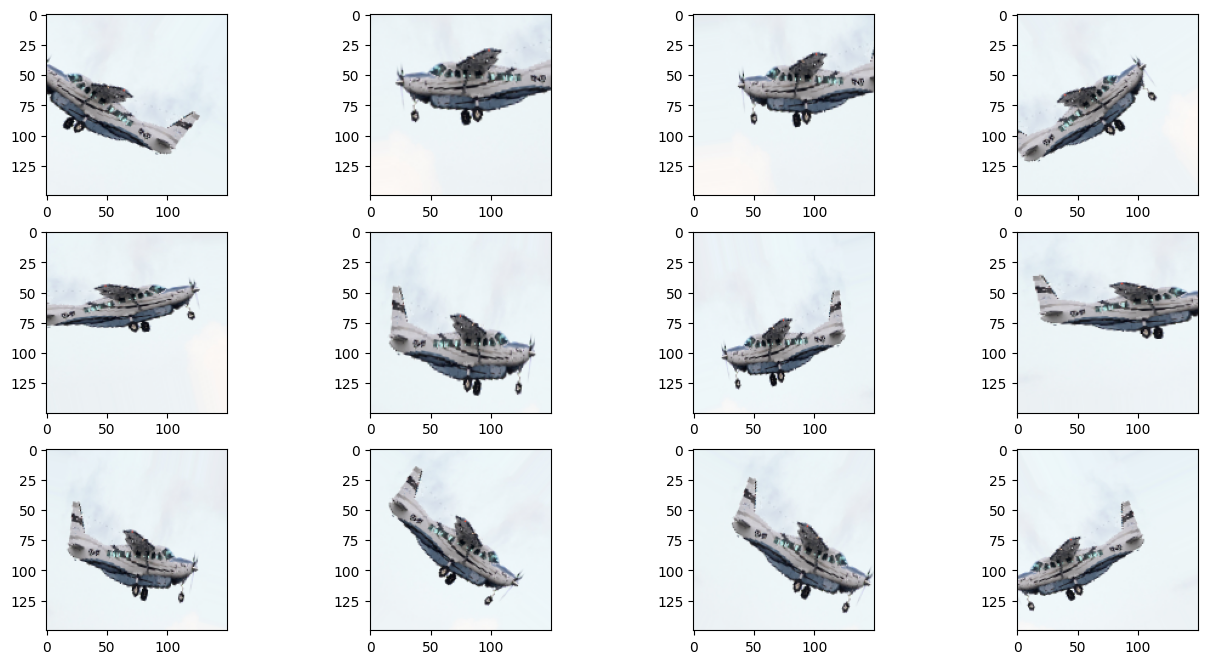

In [15]:
idx = 563 #@param {type: 'slider', mnin:0, max:919}

display_augmented_images(train_passenger_dir, idx)

###Model construction

In [16]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [19]:
batch_size = 32

steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
history = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=30,
                              validation_data = valid_generator,
                              validation_steps= validation_steps,
                              callbacks=[tensorboard])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 622ms/step - accuracy: 0.4929 - loss: 0.6984 - val_accuracy: 0.5352 - val_loss: 0.6887
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 503ms/step - accuracy: 0.5093 - loss: 0.6914 - val_accuracy: 0.5352 - val_loss: 0.6908
Epoch 3/30
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4688 - loss: 0.6994

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4838 - loss: 0.6933 - val_accuracy: 0.8333 - val_loss: 0.6594
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 58s 514ms/step - accuracy: 0.5327 - loss: 0.6899 - val_accuracy: 0.5039 - val_loss: 0.6890
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step - accuracy: 0.5352 - loss: 0.6986 - val_accuracy: 0.5820 - val_loss: 0.6755
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5960 - loss: 0.6764 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.5301 - loss: 0.6889 - val_accuracy: 0.5586 - val_loss: 0.6719
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 413ms/step - accuracy: 0.5717 - loss: 0.6820 - val_accuracy: 0.5312 - val_loss: 0.6929
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.5312 - loss: 0.6870 - val_accuracy: 0.6667 - val_loss: 0.6605
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 559ms/step - accuracy: 0.5606 - loss: 0.6741 - val_accuracy: 0.5898 - v

In [20]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

###Transfer learning - model VGG16

In [21]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model = Sequential()
model.add(layers.InputLayer(input_shape=(150, 150, 3)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
print(f'Liczba wartstw trenowanych przed zamrożeniem {len(model.trainable_weights)}')
conv_base.trainable = False
print(f'Liczba warstw trenowanych po zamrożeniu {len(model.trainable_weights)}')


Liczba wartstw trenowanych przed zamrożeniem 30
Liczba warstw trenowanych po zamrożeniu 4


In [24]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [25]:
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=validation_steps,
                    callbacks=[tensorboard])

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 737ms/step - accuracy: 0.5706 - loss: 0.7677 - val_accuracy: 0.6367 - val_loss: 0.6085
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - accuracy: 0.7044 - loss: 0.5706 - val_accuracy: 0.7930 - val_loss: 0.4760
Epoch 3/50
 2/28 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7578 - loss: 0.4883

/usr/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7651 - loss: 0.4836 - val_accuracy: 0.7500 - val_loss: 0.4604
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 52s 551ms/step - accuracy: 0.7574 - loss: 0.5090 - val_accuracy: 0.7656 - val_loss: 0.4774
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 489ms/step - accuracy: 0.7497 - loss: 0.4915 - val_accuracy: 0.7617 - val_loss: 0.4654
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.7349 - loss: 0.4453 - val_accuracy: 0.5833 - val_loss: 0.5879
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 537ms/step - accuracy: 0.7322 - loss: 0.5086 - val_accuracy: 0.7812 - val_loss: 0.4604
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.7403 - loss: 0.4999 - val_accuracy: 0.7812 - val_loss: 0.4612
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8103 - loss: 0.3767 - val_accuracy: 0.6667 - val_loss: 0.5534
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 526ms/step - accuracy: 0.7774 - loss: 0.4407 - val_accuracy: 0.7734 - 

In [26]:
plot_hist(history)

###Transfer learning - VGG16 model - unfreezing the last few layers

In [27]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150,3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainbale: {layer.trainable}')

print_layers(conv_base)

layer_name: input_layer_3 trainbale: True
layer_name: block1_conv1  trainbale: True
layer_name: block1_conv2  trainbale: True
layer_name: block1_pool   trainbale: True
layer_name: block2_conv1  trainbale: True
layer_name: block2_conv2  trainbale: True
layer_name: block2_pool   trainbale: True
layer_name: block3_conv1  trainbale: True
layer_name: block3_conv2  trainbale: True
layer_name: block3_conv3  trainbale: True
layer_name: block3_pool   trainbale: True
layer_name: block4_conv1  trainbale: True
layer_name: block4_conv2  trainbale: True
layer_name: block4_conv3  trainbale: True
layer_name: block4_pool   trainbale: True
layer_name: block5_conv1  trainbale: True
layer_name: block5_conv2  trainbale: True
layer_name: block5_conv3  trainbale: True
layer_name: block5_pool   trainbale: True


In [29]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_layer_3 trainbale: False
layer_name: block1_conv1  trainbale: False
layer_name: block1_conv2  trainbale: False
layer_name: block1_pool   trainbale: False
layer_name: block2_conv1  trainbale: False
layer_name: block2_conv2  trainbale: False
layer_name: block2_pool   trainbale: False
layer_name: block3_conv1  trainbale: False
layer_name: block3_conv2  trainbale: False
layer_name: block3_conv3  trainbale: False
layer_name: block3_pool   trainbale: False
layer_name: block4_conv1  trainbale: False
layer_name: block4_conv2  trainbale: False
layer_name: block4_conv3  trainbale: False
layer_name: block4_pool   trainbale: False
layer_name: block5_conv1  trainbale: True
layer_name: block5_conv2  trainbale: True
layer_name: block5_conv3  trainbale: True
layer_name: block5_pool   trainbale: True


In [31]:
model = Sequential()
model.add(layers.InputLayer(input_shape=(150, 150, 3)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning:

Argument `input_shape` is deprecated. Use `shape` instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [33]:
history = model.fit(train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 588ms/step - accuracy: 0.5685 - loss: 0.6787 - val_accuracy: 0.6992 - val_loss: 0.5634
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 501ms/step - accuracy: 0.7094 - loss: 0.5745 - val_accuracy: 0.7695 - val_loss: 0.4917
Epoch 3/30
 2/28 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6797 - loss: 0.5374

/usr/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6724 - loss: 0.5431 - val_accuracy: 0.8333 - val_loss: 0.3648
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 589ms/step - accuracy: 0.7291 - loss: 0.5341 - val_accuracy: 0.7812 - val_loss: 0.4517
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.7955 - loss: 0.4381 - val_accuracy: 0.7930 - val_loss: 0.4218
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.4480 - val_accuracy: 0.6667 - val_loss: 0.5744
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 549ms/step - accuracy: 0.7920 - loss: 0.4513 - val_accuracy: 0.7734 - val_loss: 0.4279
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 471ms/step - accuracy: 0.7666 - loss: 0.4609 - val_accuracy: 0.7695 - val_loss: 0.4946
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7651 - loss: 0.4336 - val_accuracy: 0.8333 - val_loss: 0.2793
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 513ms/step - accuracy: 0.7926 - loss: 0.4193 - val_accuracy: 0.7773 - val

In [34]:
plot_hist(history)

###Model evaluation on a test set

In [36]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

y_prob = model.predict(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 262 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step


array([0.001861, 0.001005, 0.002586, 0.598085, 0.000669, 0.000279,
       0.000026, 0.213433, 0.512772, 0.148845, 0.529842, 0.884977,
       0.001162, 0.005179, 0.018003, 0.10214 , 0.000981, 0.045328,
       0.040333, 0.168709, 0.101902, 0.523522, 0.000253, 0.00939 ,
       0.714259, 0.170812, 0.117933, 0.522122, 0.000277, 0.006242,
       0.059102, 0.02135 , 0.018313, 0.252557, 0.000721, 0.121416,
       0.002766, 0.07427 , 0.016554, 0.105065, 0.18256 , 0.002836,
       0.090503, 0.536546, 0.028693, 0.3284  , 0.012445, 0.006942,
       0.015513, 0.00013 , 0.000652, 0.008133, 0.000092, 0.02337 ,
       0.074947, 0.000871, 0.965369, 0.046615, 0.731164, 0.700508,
       0.000371, 0.963666, 0.02709 , 0.054084, 0.001499, 0.017726,
       0.027668, 0.124304, 0.099595, 0.021487, 0.003372, 0.432472,
       0.014637, 0.169475, 0.032943, 0.416577, 0.803867, 0.055394,
       0.083007, 0.030938, 0.454524, 0.430342, 0.177169, 0.254784,
       0.033537, 0.075386, 0.257657, 0.168709, 0.076861, 0.139

In [37]:
predictions = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,0.001861,0
1,0.001005,0
2,0.002586,0
3,0.598085,1
4,0.000669,0
...,...,...
257,0.997823,1
258,0.966870,1
259,0.647609,1
260,0.496405,0


In [38]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [39]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [40]:
test_generator.class_indices

{'drone': 0, 'passenger': 1}

In [41]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[114,  17],
       [ 17, 114]])

In [42]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       131
           1       0.87      0.87      0.87       131

    accuracy                           0.87       262
   macro avg       0.87      0.87      0.87       262
weighted avg       0.87      0.87      0.87       262



###Display prediction errors

In [43]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

,y_true,y_pred
drone/00000008.jpg,0,0
drone/00000010.jpg,0,0
drone/00000019.jpg,0,0
drone/00000032.jpg,0,1
drone/00000037.jpg,0,0


In [44]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000008.jpg,0,0,0
drone/00000010.jpg,0,0,0
drone/00000019.jpg,0,0,0
drone/00000032.jpg,0,1,1
drone/00000037.jpg,0,0,0
...,...,...,...
passenger/00001415.jpg,1,1,0
passenger/00001430.jpg,1,1,0
passenger/00001444.jpg,1,1,0
passenger/00001463.jpg,1,0,1


In [45]:
errors[errors['is_incorrect'] ==1].index

Index(['drone/00000032.jpg', 'drone/00000090.png', 'drone/00000111.jpg',
       'drone/00000112.png', 'drone/00000217.jpeg', 'drone/00000226.jpg',
       'drone/00000268.jpg', 'drone/00000409.jpg', 'drone/00000598.jpg',
       'drone/00000609.jpg', 'drone/00000612.jpg', 'drone/00000656.jpg',
       'drone/00000752.jpg', 'drone/00000906.jpg', 'drone/00001015.jpg',
       'drone/00001034.jpeg', 'drone/00001284.jpg', 'passenger/00000147.jpg',
       'passenger/00000370.jpg', 'passenger/00000443.jpg',
       'passenger/00000556.jpg', 'passenger/00000615.jpg',
       'passenger/00000641.jpg', 'passenger/00000664.jpg',
       'passenger/00000736.jpg', 'passenger/00000772.jpg',
       'passenger/00000868.jpg', 'passenger/00000984.jpg',
       'passenger/00001050.jpg', 'passenger/00001060.jpg',
       'passenger/00001148.jpeg', 'passenger/00001164.jpg',
       'passenger/00001281.png', 'passenger/00001463.jpg'],
      dtype='object')

(-0.5, 599.5, 543.5, -0.5)

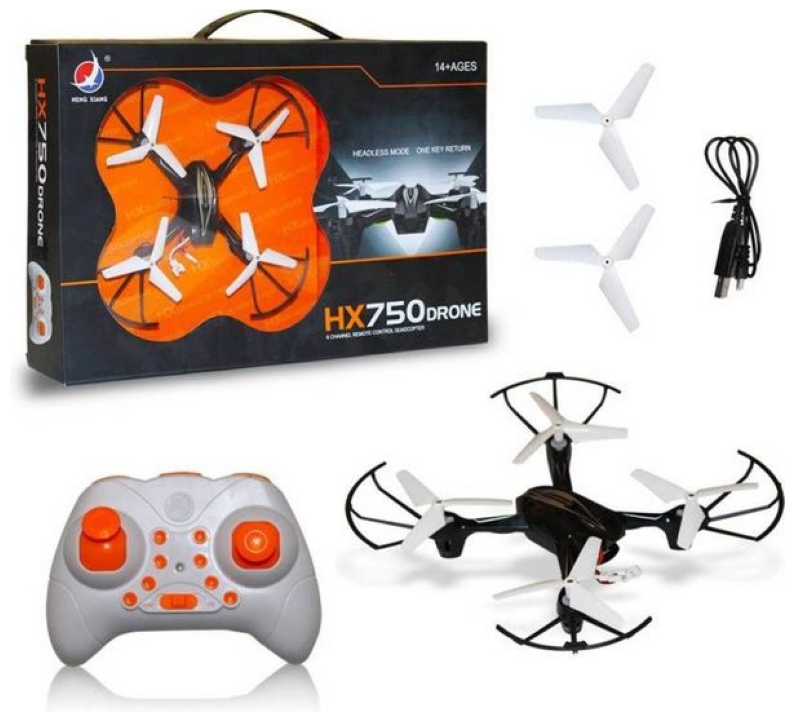

In [48]:
img_path = os.path.join(test_drone_dir, '00000032.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 349.5, 349.5, -0.5)

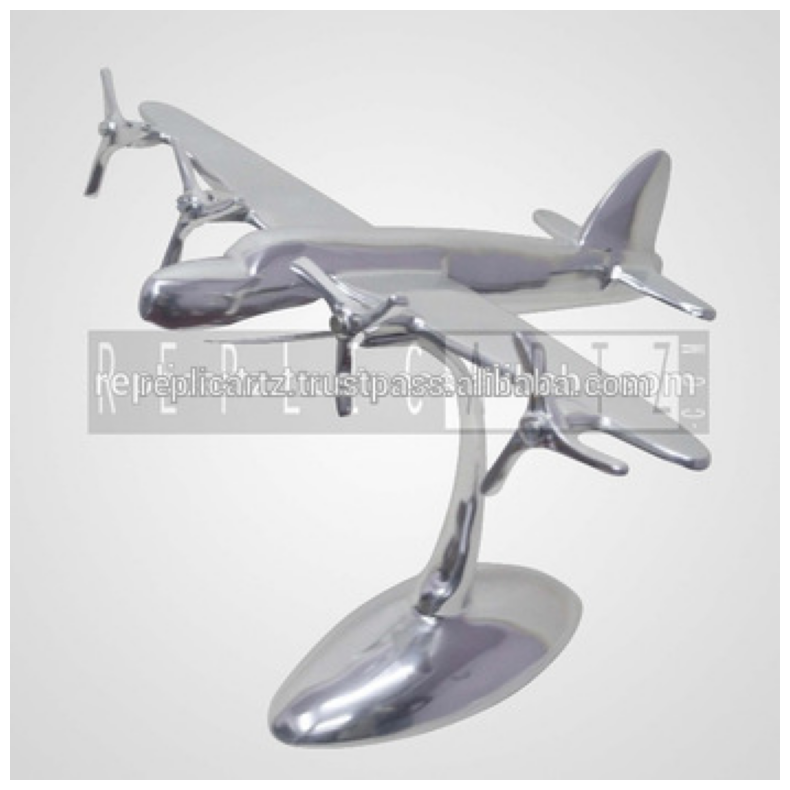

In [49]:
img_path = os.path.join(test_passenger_dir, '00000443.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)